<a href="https://colab.research.google.com/github/thhtruc/NeuralNetwork/blob/main/CIFAR_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torch

In [8]:
num_workers = 0
batch_size = 20
valid_size = 0.2
transform = torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1),
                                    torchvision.transforms.ToTensor()])

train_data = datasets.CIFAR10('train_data_CIFAR', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('test_data_CIFAR', train=False,
                             download=True, transform=transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [9]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([20, 1, 32, 32])
torch.Size([20])


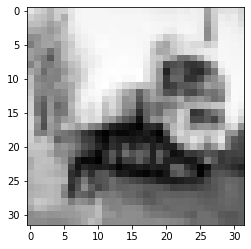

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

images, labels = next(iter(train_loader))
img = images[0].view(1, 1024)

plt.imshow(images[0].numpy().squeeze(), cmap='Greys_r')
plt.show()

In [14]:
import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
    """define the MLP."""
    def __init__(self, hidden_layers, dropout=0.5):
        super(MLP, self).__init__()
        hidden_1 = hidden_layers[0]
        hidden_2 = hidden_layers[1]
        self.fc1 = nn.Linear(32 * 32, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [15]:
# initialize the NN
model = MLP(hidden_layers=[512, 256])
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

MLP(
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [19]:
import time


tic = time.time()
epochs = 10
train_losses, valid_losses = [], []
for epoch in range(epochs):
    train_loss = 0
    valid_loss = 0

    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss/len(train_loader.sampler)
    train_losses.append(train_loss)
    

    model.eval() # prep model for evaluation
    for images, labels in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the loss
        loss = criterion(output, labels)
        # update running validation loss 
        valid_loss += loss.item()
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_losses.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))

toc = time.time()
print("Time:", 1000000*(toc-tic), "s")

Epoch: 1 	Training Loss: 0.092842 	Validation Loss: 0.090609
Epoch: 2 	Training Loss: 0.092226 	Validation Loss: 0.089267
Epoch: 3 	Training Loss: 0.091885 	Validation Loss: 0.090213
Epoch: 4 	Training Loss: 0.091113 	Validation Loss: 0.088737
Epoch: 5 	Training Loss: 0.090494 	Validation Loss: 0.087589
Epoch: 6 	Training Loss: 0.090054 	Validation Loss: 0.087123
Epoch: 7 	Training Loss: 0.089446 	Validation Loss: 0.087313
Epoch: 8 	Training Loss: 0.088893 	Validation Loss: 0.085972
Epoch: 9 	Training Loss: 0.088452 	Validation Loss: 0.085578
Epoch: 10 	Training Loss: 0.088118 	Validation Loss: 0.085068
Time: 153722375.86975098 s


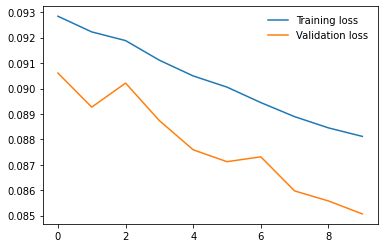

In [20]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [17]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
print(class_correct)
class_total = list(0. for i in range(10))
print(class_total)

model.eval()
for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Test Loss: 1.798933

Test Accuracy of airplane: 22% (221/1000)
Test Accuracy of automobile: 35% (357/1000)
Test Accuracy of  bird: 36% (366/1000)
Test Accuracy of   cat: 21% (218/1000)
Test Accuracy of  deer: 26% (269/1000)
Test Accuracy of   dog: 25% (255/1000)
Test Accuracy of  frog: 48% (489/1000)
Test Accuracy of horse: 37% (373/1000)
Test Accuracy of  ship: 55% (551/1000)
Test Accuracy of truck: 56% (562/1000)

Test Accuracy (Overall): 36% (3661/10000)
